# CelebA Dataset - Smile Recognition

In [1]:
import torch
import torch.nn as nn

import torchvision
from torchvision import transforms

from torch.utils.data import DataLoader, Subset

import matplotlib.pyplot as plt

import numpy as np

In [2]:
image_path = './'

train_data = torchvision.datasets.CelebA(image_path, split='train', target_type='attr', download=True)
valid_data = torchvision.datasets.CelebA(image_path, split='valid', target_type='attr', download=True)
test_data = torchvision.datasets.CelebA(image_path, split='test', target_type='attr', download=True)


print(f'Training set size: {len(train_data)}')
print(f'Validation set size: {len(valid_data)}')
print(f'Test set size: {len(test_data)}')

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Training set size: 162770
Validation set size: 19867
Test set size: 19962


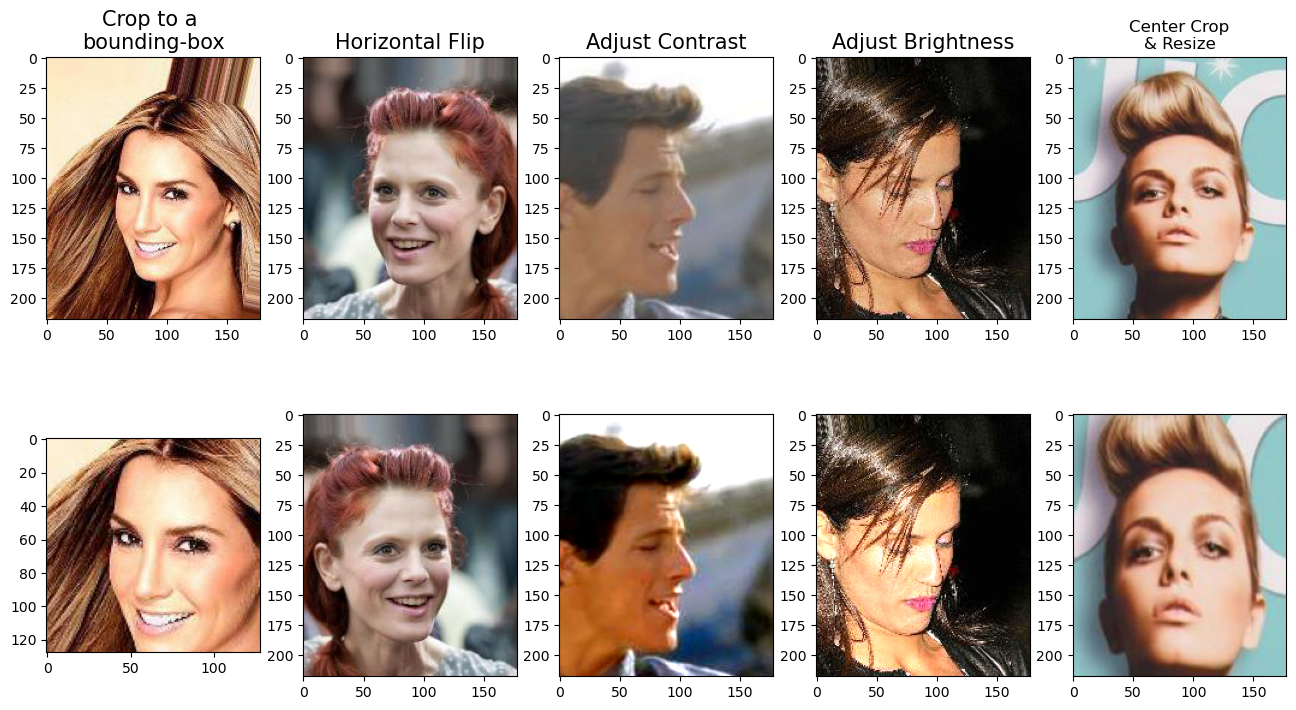

In [3]:
fig = plt.figure(figsize=(16, 8.5))

# Col 1: Cropping to a bounding-box
ax = fig.add_subplot(2, 5, 1)
img, attr = train_data[0]
ax.set_title('Crop to a \nbounding-box', size=15)
ax.imshow(img)
ax = fig.add_subplot(2, 5, 6)
img_cropped = transforms.functional.crop(img, 50, 20, 128, 128)
ax.imshow(img_cropped)

# Col 2: Horizontal flips
ax = fig.add_subplot(2, 5, 2)
img, attr = train_data[1]
ax.set_title('Horizontal Flip', size=15)
ax.imshow(img)
ax = fig.add_subplot(2, 5, 7)
img_flipped = transforms.functional.hflip(img)
ax.imshow(img_flipped)

# Col 3: Adjust Contrast
ax = fig.add_subplot(2, 5, 3)
img, attr = train_data[2]
ax.set_title('Adjust Contrast', size=15)
ax.imshow(img)
ax = fig.add_subplot(2, 5, 8)
img_adj_contrast = transforms.functional.adjust_contrast(img, contrast_factor=2)
ax.imshow(img_adj_contrast)

# Col 4: Adjust Brightness
ax = fig.add_subplot(2, 5, 4)
img, attr = train_data[3]
ax.set_title('Adjust Brightness', size=15)
ax.imshow(img)
ax = fig.add_subplot(2, 5, 9)
img_adj_brightness = transforms.functional.adjust_brightness(img, brightness_factor=1.3)
ax.imshow(img_adj_brightness)

# Col 5: Cropping from image center
ax = fig.add_subplot(2, 5, 5)
img, attr = train_data[4]
ax.set_title('Center Crop\n& Resize')
ax.imshow(img)
ax = fig.add_subplot(2, 5, 10)
img_center_crop = transforms.functional.center_crop(img, [0.7 * 218, 0.7 * 218])
img_resized = transforms.functional.resize(img_center_crop, size = (218, 178))
ax.imshow(img_resized)

plt.show()

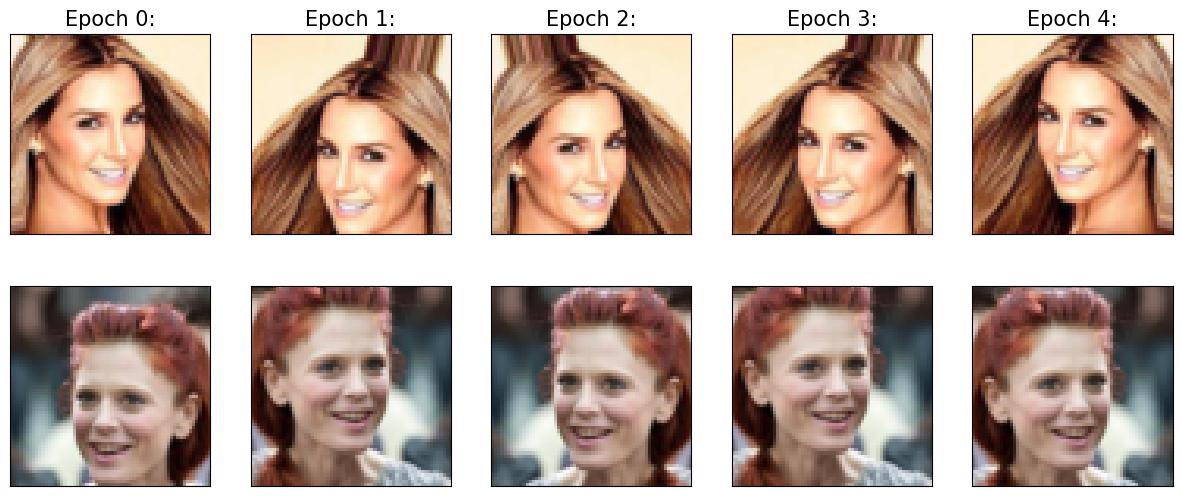

In [4]:
# These transformations are deterministic
# To truly have variety in the training data, they need to be randomized

transform_train = transforms.Compose([
    transforms.RandomCrop([178, 178]),
    transforms.RandomHorizontalFlip(),
    transforms.Resize([64, 64]),
    transforms.ToTensor(),
])

# For validation, we will just use a deterministic cropping and resizing
transform = transforms.Compose([
    transforms.CenterCrop([178, 178]),
    transforms.Resize([64, 64]),
    transforms.ToTensor(),
])

# Get the target labels as well (it is element index 31 of the associated attributes)
get_smile = lambda attr: attr[31]

# Create the training data
train_data = torchvision.datasets.CelebA(image_path, split='train', target_type='attr', download=False, transform=transform_train, target_transform=get_smile)

# Create the dataloader for it
torch.manual_seed(42)
dataloader = DataLoader(train_data, batch_size=2)

# Let's see how the randomization works
num_iter = 5

fig = plt.figure(figsize=(15, 6))
for j in range(num_iter):
    img_batch, label_batch = next(iter(dataloader))
    
    img = img_batch[0]
    ax = fig.add_subplot(2, 5, j + 1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'Epoch {j}:', size=15)
    ax.imshow(img.permute(1, 2, 0))

    img = img_batch[1]
    ax = fig.add_subplot(2, 5, j + num_iter + 1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(img.permute(1, 2, 0))

plt.show()

In [13]:
valid_data = torchvision.datasets.CelebA(image_path, split='valid', target_type='attr', download=False, transform=transform, target_transform=get_smile)
test_data = torchvision.datasets.CelebA(image_path, split='test', target_type='attr', download=False, transform=transform, target_transform=get_smile)

# Train and validate with an even smaller dataset
mini_train_data = Subset(train_data, torch.arange(16000))
mini_valid_data = Subset(valid_data, torch.arange(1000))

batch_size = 32
torch.manual_seed(42)
train_dl = DataLoader(mini_train_data, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(mini_valid_data, batch_size=batch_size, shuffle=False)
test_dl = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [6]:
# Create the classifier module

# Start with sparse convolutional layers
model = nn.Sequential()

model.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1))
model.add_module('relu1', nn.ReLU())
model.add_module('pool1', nn.MaxPool2d(kernel_size=2))
model.add_module('dopout1', nn.Dropout(p=0.5))

model.add_module('conv2', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1))
model.add_module('relu2', nn.ReLU())
model.add_module('pool2', nn.MaxPool2d(kernel_size=2))
model.add_module('dopout2', nn.Dropout(p=0.5))

model.add_module('conv3', nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1))
model.add_module('relu3', nn.ReLU())
model.add_module('pool3', nn.MaxPool2d(kernel_size=2))

model.add_module('conv4', nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1))
model.add_module('relu4', nn.ReLU())

one_inp = torch.ones(4, 3, 64, 64)
print(model(one_inp).shape)

torch.Size([4, 256, 8, 8])


In [7]:
# We can flatten the feature maps, but this will create 8 x 8 x 256 input units into the fully connected layer
# To reduce this, we can use global average pooling over the 8 x 8 parts, which will reduce it to 256 input units
model.add_module('pool4', nn.AvgPool2d(kernel_size=8))
model.add_module('flatten', nn.Flatten())
print(model(one_inp).shape)

torch.Size([4, 256])


In [8]:
model.add_module('fc', nn.Linear(256, 1))
model.add_module('sigmoid', nn.Sigmoid())
print(model(one_inp).shape)
print(f'\nModel Structure:\n{model}')

torch.Size([4, 1])

Model Structure:
Sequential(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dopout1): Dropout(p=0.5, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dopout2): Dropout(p=0.5, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu4): ReLU()
  (pool4): AvgPool2d(kernel_size=8, stride=8, padding=0)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [9]:
loss_func = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def train(model, num_epochs, train_dl, valid_dl):
    loss_hist = {}
    loss_hist['train'] = [0] * num_epochs
    loss_hist['valid'] = [0] * num_epochs

    acc_hist = {}
    acc_hist['train'] = [0] * num_epochs
    acc_hist['valid'] = [0] * num_epochs

    for epoch in range(num_epochs):
        # Set the model to training mode, where the dropout is active
        model.train()

        for x_batch, y_batch in train_dl:
            pred = model(x_batch)[:, 0]
            loss = loss_func(pred, y_batch.float())

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            loss_hist['train'][epoch] += loss.item() * y_batch.size(0)
            correct_preds = ((pred >= 0.5).float() == y_batch).float()
            acc_hist['train'][epoch] += correct_preds.sum()
        
        loss_hist['train'][epoch] /= len(train_dl.dataset)
        acc_hist['train'][epoch] /= len(train_dl.dataset)

        model.eval()

        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                pred = model(x_batch)[:, 0]
                loss = loss_func(pred, y_batch.float())

                loss_hist['valid'][epoch] += loss.item() * y_batch.size(0)
                correct_preds = ((pred >= 0.5).float() == y_batch).float()
                acc_hist['valid'][epoch] += correct_preds.sum()

        loss_hist['valid'][epoch] /= len(valid_dl.dataset)
        acc_hist['valid'][epoch] /= len(valid_dl.dataset)

        print(f'Epoch {epoch + 1}\nTraining accuracy: {acc_hist['train'][epoch]:.4f}')
        print(f'Validation accuracy: {acc_hist['valid'][epoch]:.4f}')
    
    return loss_hist['train'], loss_hist['valid'], acc_hist['train'], acc_hist['valid']

In [10]:
torch.manual_seed(42)
hist = train(model=model, num_epochs=30, train_dl=train_dl, valid_dl=valid_dl)

Epoch 1
Training accuracy: 0.5268
Validation accuracy: 0.5100
Epoch 2
Training accuracy: 0.5523
Validation accuracy: 0.5870
Epoch 3
Training accuracy: 0.5893
Validation accuracy: 0.5710
Epoch 4
Training accuracy: 0.6126
Validation accuracy: 0.6430
Epoch 5
Training accuracy: 0.6321
Validation accuracy: 0.6130
Epoch 6
Training accuracy: 0.6431
Validation accuracy: 0.6360
Epoch 7
Training accuracy: 0.6556
Validation accuracy: 0.6460
Epoch 8
Training accuracy: 0.6608
Validation accuracy: 0.6590
Epoch 9
Training accuracy: 0.6761
Validation accuracy: 0.6880
Epoch 10
Training accuracy: 0.6969
Validation accuracy: 0.7030
Epoch 11
Training accuracy: 0.7153
Validation accuracy: 0.7450
Epoch 12
Training accuracy: 0.7412
Validation accuracy: 0.7740
Epoch 13
Training accuracy: 0.7680
Validation accuracy: 0.8060
Epoch 14
Training accuracy: 0.7866
Validation accuracy: 0.8350
Epoch 15
Training accuracy: 0.8106
Validation accuracy: 0.8290
Epoch 16
Training accuracy: 0.8167
Validation accuracy: 0.8610
E

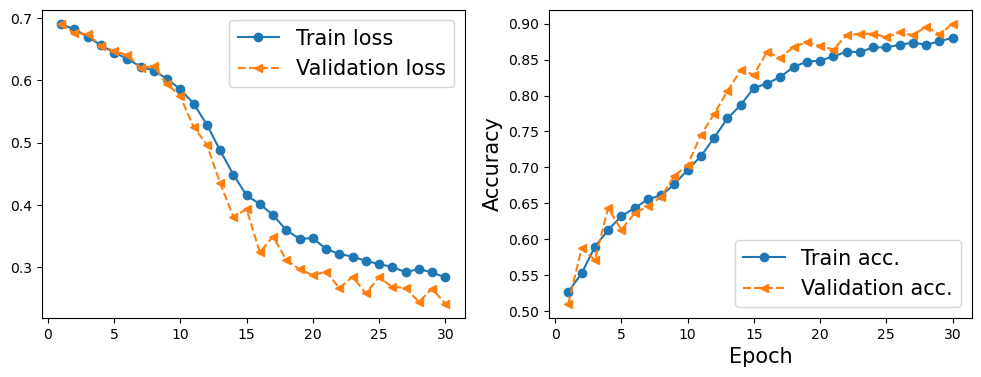

In [11]:
x_arr = np.arange(len(hist[0])) + 1
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist[0], '-o', label='Train loss')
ax.plot(x_arr, hist[1], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist[2], '-o', label='Train acc.')
ax.plot(x_arr, hist[3], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)
plt.show()

In [14]:
accuracy_test = 0
model.eval()
with torch.no_grad():
    for x_batch, y_batch in test_dl:
        pred = model(x_batch)[:, 0]
        is_correct = ((pred>=0.5).float() == y_batch).float()
        accuracy_test += is_correct.sum()
accuracy_test /= len(test_dl.dataset)
print(f'Test accuracy: {accuracy_test:.4f}')

Test accuracy: 0.9032


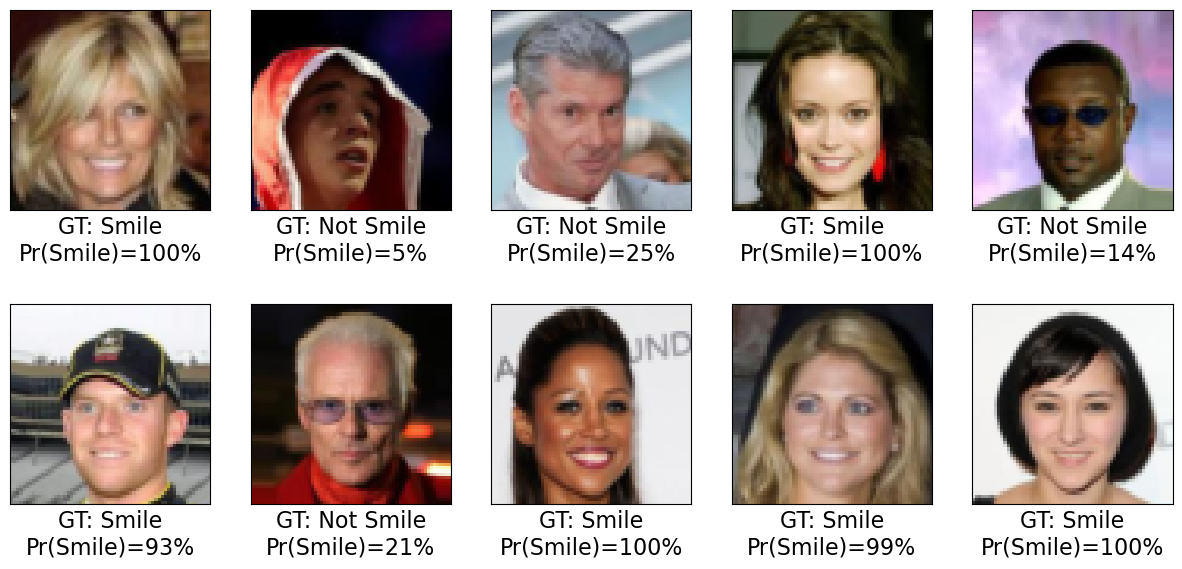

In [15]:
pred = model(x_batch)[:, 0] * 100
fig = plt.figure(figsize=(15, 7))
for j in range(10, 20):
    ax = fig.add_subplot(2, 5, j-10+1)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(x_batch[j].permute(1, 2, 0))
    if y_batch[j] == 1:
        label='Smile'
    else:
        label = 'Not Smile'
    ax.text(0.5, -0.15, f'GT: {label:s}\nPr(Smile)={pred[j]:.0f}%', size=16, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
plt.show()